In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client


In [1]:
import os
import openai
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')

In [2]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", max_new_tokens=1500,temperature = 0.02
)

In [2]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
# image_store = QdrantVectorStore(
#     client=client, collection_name="image_collection"
# )
storage_context = StorageContext.from_defaults(vector_store=text_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_data_output/text_file/", recursive=True, exclude_hidden=True).load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

/home/huzaifa/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [4]:
def get_embed_model():
    model = FlagModel('BAAI/bge-large-en-v1.5', 
                    query_instruction_for_retrieval="Represent this sentence for searching relevant passages: ",
                    use_fp16=True)
    return model

In [3]:
from llama_index.embeddings import HuggingFaceEmbedding
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

/home/huzaifa/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

KeyboardInterrupt: 

In [5]:
embed_model = get_embed_model()

In [3]:
from llama_index.vector_stores import ChromaVectorStore
from llama_index.storage.storage_context import StorageContext
import chromadb
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext


In [4]:
documents = SimpleDirectoryReader("./mixed_data_output/text_file/", recursive=True, exclude_hidden=True).load_data()

In [5]:
len(documents)

16

In [7]:
from llama_index import Document

documents = Document(text="\n\n".join([doc.text for doc in documents]))

In [8]:
db = chromadb.PersistentClient(path="./chroma_db")
chroma_collection = db.get_or_create_collection("quickstart")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
# service_context = ServiceContext.from_defaults(embed_model=embed_model)
index = VectorStoreIndex.from_documents(
    [documents], storage_context=storage_context, 
)



In [6]:
# load from disk
db2 = chromadb.PersistentClient(path="./chroma_db")
chroma_collection = db2.get_or_create_collection("quickstart")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
index = VectorStoreIndex.from_vector_store(
    vector_store,
)

# Query Data from the persisted index
# query_engine = index.as_query_engine()
# response = query_engine.query("What did the author do growing up?")
# display(Markdown(f"<b>{response}</b>"))

In [7]:
from llama_index.prompts import PromptTemplate
# from llama_index.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    """
    Context information is below.\
    ---------------------\
    {context_str}\
    Given the context information and not prior knowledge, \
    If your query is related to [specific topic or process or guide], keep the steps exactly the same as the Context information. here are the steps to follow:
    Step 1: [Step 1 Text]
    Step 2: [Step 2 Text]
    ...
    Step N: [Step N Text]
    don't add any steps unnecessary
    Query: {query_str}\
    Answer: 
    """
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
     multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
)



In [8]:
def input_user_guery(query_str):
    response = query_engine.query(query_str)
    return response

### Regex to convert response into list of steps

In [9]:
# using regex to convert the response into the list of steps

import re

def response_to_list(response):
    steps_pattern = re.compile(r"Step \d+: .+")
    steps_list = steps_pattern.findall(str(response))
    
    # Wrap each step in the desired format
    formatted_steps = [f"{step}" for step in steps_list]
    
    return formatted_steps



## Retrieve The Image

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import base64
from openai import OpenAI
from PIL import Image
from FlagEmbedding import FlagModel

/home/huzaifa/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="Represent this sentence for searching relevant passages: ",
                  use_fp16=True)

In [12]:
def load_image(url_or_path):
    # if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
    #     return Image.open(requests.get(url_or_path, stream=True).raw)
    # else:
    try:
        img = Image.open(url_or_path)
        return img
    except FileNotFoundError:
        return None


In [13]:

def cosine_similarity(vec1, vec2):
    # Compute the dot product of vec1 and vec2
    dot_product = np.dot(vec1, vec2)

    # Compute the L2 norm of vec1 and vec2
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Compute the cosine similarity
    similarity = dot_product / (norm_vec1 * norm_vec2)
    
    return similarity

In [11]:
# def encode_image(image_path):
#         if pd.notna(image_path):
#                 with open(image_path, "rb") as image_file:
#                         return base64.b64encode(image_file.read()).decode('utf-8')
#         else:
#                 return None

# headers = {
#         "Content-Type": "application/json",
#         "Authorization": f"Bearer {openai.api_key}"
# }
# client = OpenAI()

In [12]:
# def question_image(image_path,query):
    
#     base64_image = encode_image(image_path)
#     if base64_image is not None:
#         payload = {
#             "model": "gpt-4-vision-preview",
#             "messages": [
#                 {
#                 "role": "user",
#                 "content": [
#                     {
#                     "type": "text",
#                     "text": f"{query}?"
#                     },
#                     {
#                     "type": "image_url",
#                     "image_url": {
#                         "url": f"data:image/jpeg;base64,{base64_image}"
#                     },
#                     }
#                 ]
#                 }
#             ],
#             "max_tokens": 1000
#         }

#         response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

#         temp=response.json()
#         return temp['choices'][0]['message']['content']


In [11]:
data=pd.read_excel(r"registration_banking_details.xlsx")

In [14]:
# data['imageDescription']=None
# query="Highlight the key features of the image."
# for i,row in data.iterrows():
#     image_path=row['image_path']
#     try:
#         desc=question_image(image_path,query)
#         data.at[i,'imageDescription']=desc
#     except requests.exceptions.RequestException:
#         continue


In [12]:
data['embedding']=None
for i,row in data.iterrows():
    temp=row['image_step']
    data.at[i,'embedding']=model.encode(temp)

In [13]:
# for writing in excel

data['embedding'] = data['embedding'].apply(lambda x: x.tolist())
data.to_excel("bank_app_data_embedding_3.xlsx")

In [14]:
# reading from excel

import numpy as np
import json
import pandas as pd
data = pd.read_excel("bank_app_data_embedding_3.xlsx")

def convert_embedding(x):
    try:
        return np.array(json.loads(x))
    except (json.JSONDecodeError, TypeError):
        return np.nan  # or any other value to represent missing data

# Apply the function only to non-empty values in the 'embedding' column
data['embedding'] = data['embedding'].apply(lambda x: convert_embedding(x) if x else np.nan)



In [15]:
def top_products(user_input):
    user_embedding=model.encode(user_input)
    data['scores']=None
    for i,row in data.iterrows():
        data.at[i,'scores']=cosine_similarity(user_embedding,row['embedding'])
    data['scores'] = pd.to_numeric(data['scores'], errors='coerce')
    top_product=data.nlargest(1,'scores') 
    if pd.notna(top_product['image_path'].iloc[0]):
        image = load_image(top_product['image_path'].iloc[0])
    
        fig, axs = plt.subplots(figsize=(5, 5))
        axs.imshow(np.array(image))
        axs.axis('off')

        plt.show()


     

In [16]:
def get_response(user_guery):
    response = input_user_guery(user_guery)
    # print(str(response))
    steps = response_to_list(str(response))

    if steps:
        for step in steps:
            inp = step
            print(step)
            top_products(inp)
    else: 
        print(str(response))   

Step 1: In the main menu of the banking app, select the "Mobile Top Up" option.


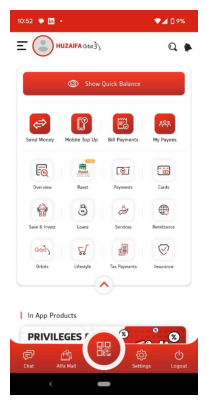

Step 2: On the Mobile Top Up page, select the "Mobile Packages" option.


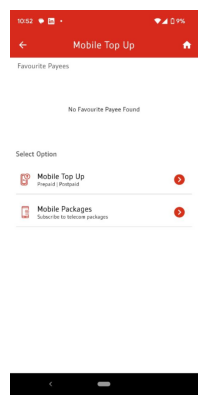

Step 3: Choose the mobile network and mobile package that you want to load.


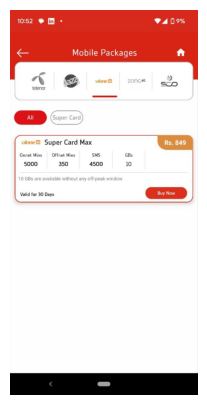

Step 4: On the Mobile Packages page, enter the mobile number for which you want to load the package.


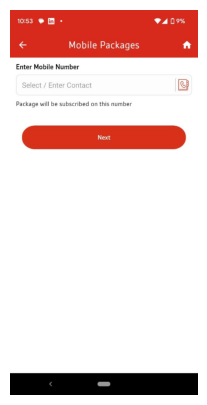

In [18]:
#  how to view e statement?
#  how to load mobile package?
#  how to register for alflah banking?
#  what is Alfalah Orbit Rewards?
user_query = 'how to load mobile package?'
get_response(user_query)